<center>Заметка 5.а Морфологические операторы</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.095</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

Импортируем необходимые библиотеки:

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

<h1>Морфологические операторы</h1>

<h2>Теория</h2>

<h3>Добавление шума соль/перец</h3>

In [74]:
img_bin = np.load("./img_bin.npy")    # загрузка изображения без шума

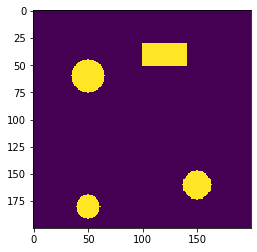

In [75]:
plt.imshow( img_bin, interpolation = 'none' );    # отрисовка изображения

<h2>Траффареты</h2>

<h3>Удаляем шум</h3>

In [76]:
img_salt = np.load("./img_salt.npy")    # загрузка изображения с шумом

Покажем исходное изображение с шумом.

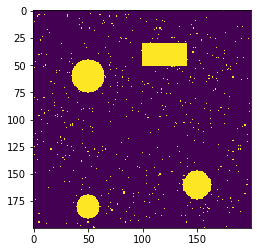

In [77]:
plt.imshow( img_salt, interpolation = 'none' );

Вот так выглядит фрагмент изображение с шумом типа соль.

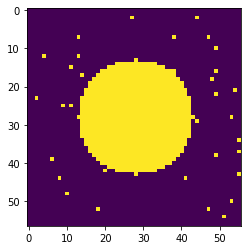

In [78]:
plt.imshow( img_salt[32:89, 22:78] );

На изображении выше видно, что шум - это одиночные точки.\
То есть это фрагмент 3х3, где в центре пиксель, соответсвующий значению 1, а вокруг пиксели, соответсвующие значению 0.\
Попробуем избавиться от таких фрагментов.

<b>Маска единичного шума</b>

Создадим маску, **трафарет**. \
Она будет соответствовать куску изображения 3 на 3 с единичной точкой в центре.

In [87]:
# единичная соль
s = np.array(
[[0,0,0],
 [0,1,0],
 [0,0,0]])

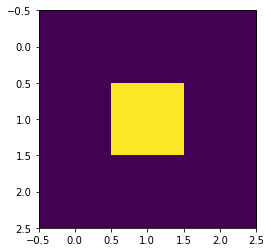

In [88]:
# Изображение трафарета для единичного шума.
plt.imshow( s );

<b>Поиск совпадений по маске/трафарету</b>

Будем бегать по изображению окном 3 на 3.
Искать те фрагменты, которые подходят под бинарный образец в точности.
Фактически, будет проверятся на совпадение матрицы 3 на 3 со содержимом  окна.

In [90]:
# Создадим выходное изображение из нулей размера равного размеру нашего образца с шумом.
img_cycle = np.zeros_like(img_salt)

In [91]:
# Бегаем по всем пикселям.
for i in range( 1, img_salt.shape[0] - 1 ):# По всем рядам.
    for j in range( 1, img_salt.shape[1] - 1 ):# По всем колонкам.
        v = img_salt[i,j] # Считываем исходное значение.
        m = img_salt[i-1:i+2,j-1:j+2] # Считываем значения подматрицы/окна 3 на 3.
        if (m == s).all(): # Проверяем что все значения совпадают.
            v = 0 # В случае срабатывания трафарета полагаем значение в 0.
        img_cycle[i,j] = v # Присваиваем в выходном изображении значение.

Посмотрим на получившиеся изображение.

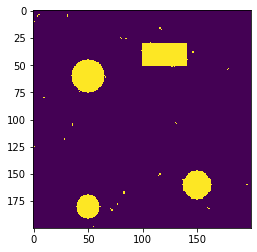

In [92]:
plt.imshow( img_cycle, interpolation = 'none' );

Видно, что картинка стала почище.
Но какой-то шум все-таки остался.
Посмотрим поближе фрагмент изображения.

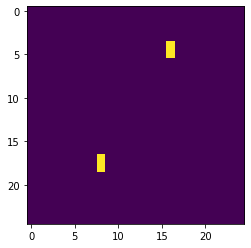

In [93]:
plt.imshow( img_cycle[100:125, 20:45] );

Видно, в чем проблема.
Не удалился шум состоящий из более чем одной точки.
С точки зрения теории вероятности такое может быть.

Метод на трафареты расширяется на множество трафаретов. Фактически идет проверка со всеми трафаретами. Если будет хотя бы одно совпадение с ними, то значит считаем, что есть совпадание.
Конечно это можно рассматривать и как последовательное применение одиночных трафаретов.

Мы могли бы рассмотреть все возможные отростки. \
То есть сделаем ещё 8 трафаретов 3х3, где центральный пиксель равен 1, \
и ещё один из восьми оставшихся равен 1 (остальные пиксели нулевые).

In [94]:
ss = [s.copy()] # Запонимаем трафарет из одной точки.
for i in range(3): # Цикл по всем другим 8 точкам
    for j in range(3): # 3 на 3 блока.
        if i==1 and j==1:
            continue
        t = s.copy()# Начинает с трафарета с центральной точкой.np.array(
            #[[0,0,0],
            #[0,1,0],
            #[0,0,0]])
        t[i,j] = 1 # Добавляем к ней краевую.
        ss.append(t)

In [95]:
len(ss) # Теперь трафаретов будет 9.

9

Пример отростка.

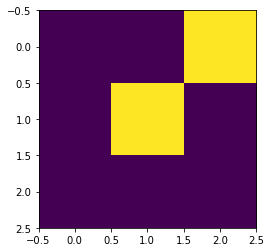

In [96]:
plt.imshow( ss[3] );

Создадим функцию на будущее.\
Она бегает по всему изображению и проверяет каждый фрагмент 3х3 на совпадение с каждым из трафаретов из списка. \
В случае совпадения записывает в выходное изображение 0,
иначе исходное значение.

In [97]:
def apply_traff( img_src, img_dst, ss):
    for i in range( 1, img_dst.shape[0] - 1 ):
        for j in range( 1, img_dst.shape[1] - 1 ):
            v = img_src[i,j]
            m = img_src[i-1:i+2,j-1:j+2]
            for t in ss: # Цикл по всем трафаретам.
                if (m == t).all():
                    v = 0
            img_dst[i,j] = v;

In [98]:
img_cycle = np.zeros_like(img_salt) # Можно и не делать.

In [99]:
apply_traff( img_salt, img_cycle, ss)

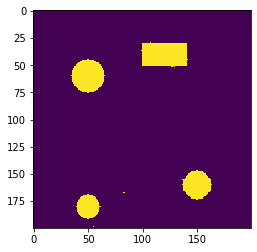

In [100]:
plt.imshow( img_cycle, interpolation = 'none'  );

Рассмотрим небольшой фрагмент изображения после удаления шума с помощью наших 9 трафаретов.

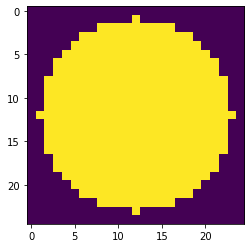

In [101]:
plt.imshow( img_cycle[168:193, 38:63] );

Сравним этот фрагментом с аналогичным фрагментом оригинального изображения(без шума)

In [102]:
(img_cycle[168:193, 38:63] == img_bin[168:193, 38:63]).all()

True

Замечу, что в данном случае фрагмент восстановился полностью.\
Но не для всех фрагментах это так.

Рассмотрим другой фрагмент

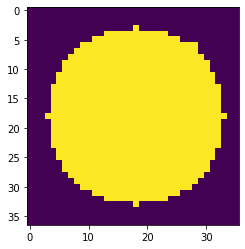

In [104]:
plt.imshow( img_cycle[42:79, 32:68] );

Также сравним этот фрагментом с аналогичным фрагментом оригинального изображения

In [105]:
(img_cycle[42:79, 32:68] == img_bin[42:79, 32:68]).all()

False

Посмотрим где ошибка.

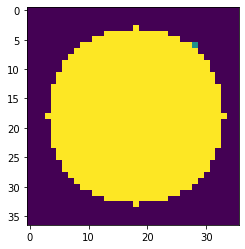

In [106]:
plt.imshow( img_cycle[42:79, 32:68] + img_bin[42:79, 32:68] );
# Там где совпадения нет, будет значение 1.

Данный шум был изначально приклеелен к кругу и не может быть убран нашими трафаретами.

<b>Оставшийся шум</b>

Посмотрим, что шум все же остался.

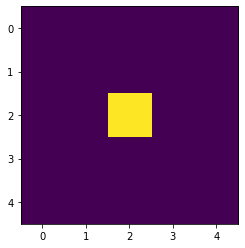

In [108]:
plt.imshow( img_cycle[165:170, 81:86] );

Он совпадает с маской... применим наш метод ещё раз

<b>Повторное применение маски</b>

In [109]:
img_cycle2 = np.zeros_like(img_cycle)

In [110]:
apply_traff( img_cycle, img_cycle2, ss)

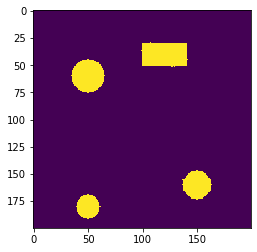

In [111]:
plt.imshow( img_cycle2, interpolation = 'none' );

И более близко:

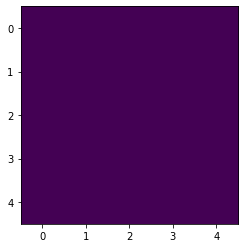

In [49]:
plt.imshow( img_cycle2[165:170, 81:86] );

Да, все чисто теперь.

Итого. Трафарет можно и нужно иногда применять больше одного раза к изображению.
Однократное применение может не достичь нужной цели.

<b>Расмотрение ещё случаев</b>

А может потребоваться рассмотрение большего количества случаев.

Рассмотрим на шум более детально наше изначальное изображение с шумом.

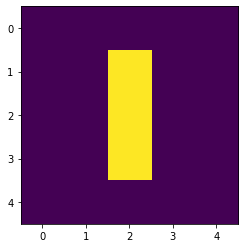

In [113]:
plt.imshow( img_salt[165:170, 81:86] );

Можно и этот случай (и подобные) добавить.
Сделаем ещё трафаретов таких, что центральный пиксель равен 1 и ещё два пикселя по краям равны 1. 

In [114]:
l = len(ss)
for i in range( l-1 ): # Последний элемент это просто точка.
    for j in range( i, l-1):
        z = ss[i] + ss[j] # Берем все их комбинации.
        z[1,1] = 1 # Восстанавливаем ценральный пиксель в единицу.
        ss.append( z ) 

In [115]:
len(ss)

45

Один из новых трафаретов выглядит так:

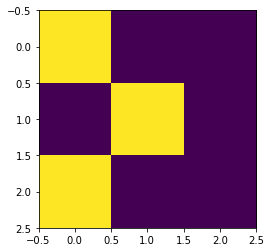

In [117]:
plt.imshow( ss[22] );

Применим теперь к изначальному изображению с шумом все имеющиеся трафареты

In [119]:
apply_traff( img_salt, img_cycle, ss)

Вроде весь шум убрали.

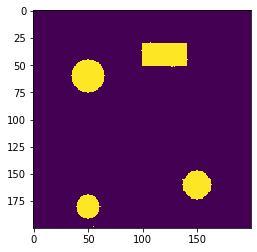

In [120]:
plt.imshow( img_cycle, interpolation = 'none'  );

Можно видеть, что с теми фрагментами, с которыми 9 старых траффаретов не справлялись, новые отлично справляются 

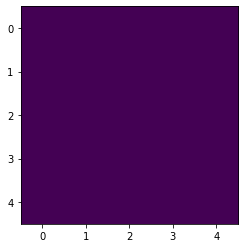

In [122]:
plt.imshow( img_cycle[165:170, 81:86] );

<h3>Заусенцы</h3>

Можно заметить, что на изображении есть **заусенцы**.\
Это шум, приклеившийся к изначальным фигурам.

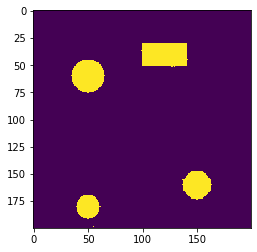

In [137]:
plt.imshow( img_cycle, interpolation = 'none'  );

Лучше всего заусенцы видны на прямоугольнике

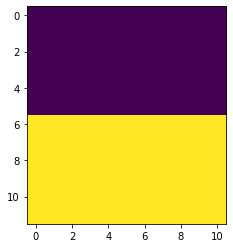

In [136]:
plt.imshow( img_cycle[24:36, 102:113] );

Нужен специальный трафарет.

In [129]:
заусенец = np.array(
[[0,0,0],
 [0,1,0],
 [1,1,1]])

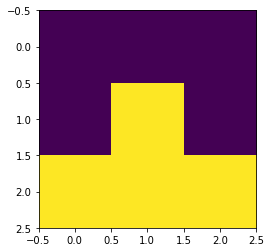

In [130]:
plt.imshow(заусенец);

Добавим новый трафарет к имеющимся и применим к изображению с шумом

In [131]:
apply_traff( img_salt, img_cycle, ss + [заусенец])

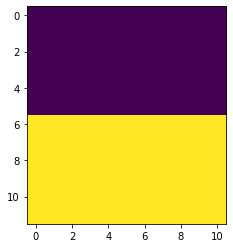

In [132]:
plt.imshow( img_cycle[24:36, 102:113] );

Как видно, заусенец убрали.

Картинка в целом стала лучше, но теперь испортились круги

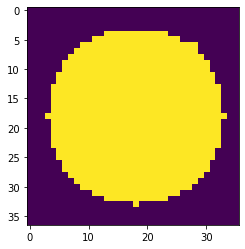

In [139]:
plt.imshow( img_cycle[42:79, 32:68]);

Таких трафаретов известно много.

<h3>Логические правила</h3>

Так задаются трафареты для разных случаев.
Их может быть много.
Один из способов их сокартить это
задать логическое правило над пикселями окрестности.

Например, сделаем логическое правило, которое делает то же, что делало применение 45 трафаретов выше (не считая тех, что удаляют заусенцы)\
1) Если центральный пискель 0, то оставляем как есть.\
2) Если центральный пиксель равен 1, а вокург него из 8 не больше двух пекселей равны 1, то сделаем его равным 0.

In [140]:
img_cycle3 = np.zeros_like(img_bin)

In [142]:
for i in range( 1, img_salt.shape[0] - 1 ):
    for j in range( 1, img_salt.shape[1] - 1 ):
        v = img_salt[i,j]
        if v==0:
            continue
        m = img_bin[i-1:i+2,j-1:j+2]
        cnt = np.count_nonzero( m )
        cnt -= 1 # Центральный
        v = 0
        if cnt>=3:
            v = 1;
        img_cycle3[i,j] = v;

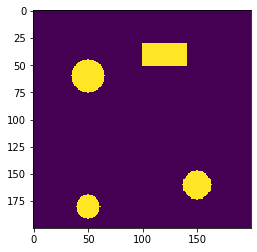

In [143]:
plt.imshow( img_cycle3, interpolation = 'none'  );

Можно заметить, что использование данного логического правила занимает гораздо меньше времени, чем применение 45 трафаретов.

<h2>Операторы</h2>

Фактически точное совпадение по трафарету разбивается на две операции: разъедание и наращивание.
Разъедание может только пиксель убрать на изображение,
а наращивание -- только нарастить.

<b>Разъедание</b>

В случае бинарных изображений:\
для всех пикселей трафарета равных 1 смотрим, все ли пиксели им соответсвующие на изображении равны 1.\
Если да, то значит оставляем пиксель, иначе делаем его равным 0.\
Напомню, что рассматриваем трафарет только для истинных пикселей (для якоря).

Рассмотрим такое изображение

In [146]:
plusses = np.array(
[
    [0, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0]
]
)
plusses.shape

(3, 6)

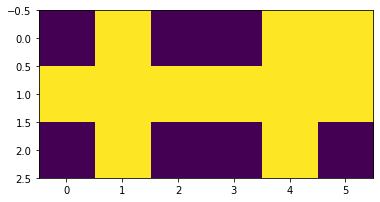

In [147]:
plt.imshow( plusses );

Разъедать будем плюсом.

In [148]:
plus = np.array(
[
    [0, 1, 0,],
    [1, 1, 1 ],
    [0, 1, 0 ]
]
)

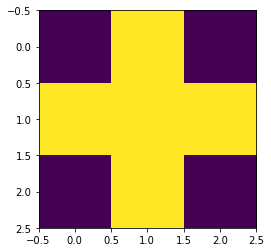

In [149]:
plt.imshow( plus );

Посмотрим, как будет двигаться данный трафарет по данному изображению

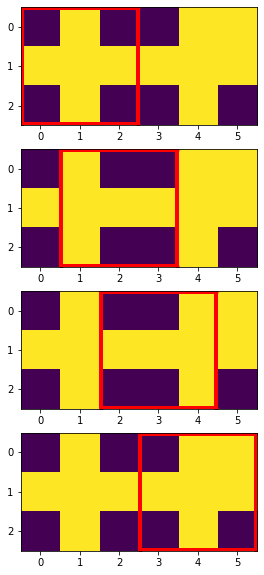

In [151]:
eps = 0.03

fig, axs = plt.subplots(4)
fig.set_size_inches(10,10)
for i in range(4):
    axs[i].imshow( plusses )
    axs[i].plot( [-0.5+eps+i, 2.5-eps+i, 2.5-eps+i, -0.5+eps+i, -0.5+eps+i], [-0.5+eps, -0.5+eps, 2.5-eps, 2.5-eps, -0.5+eps], 'r.-', linewidth=4 )

In [152]:
fplus = np.zeros_like( plusses )

In [153]:
for i in range( 1, plusses.shape[0] - 1 ):
    for j in range( 1, plusses.shape[1] - 1 ):
        v = plusses[i,j]
        if v==0:
            continue
        m = plusses[i-1:i+2,j-1:j+2]
        m = m*plus
        fplus[i,j] = np.sum(plus) == np.sum(m)

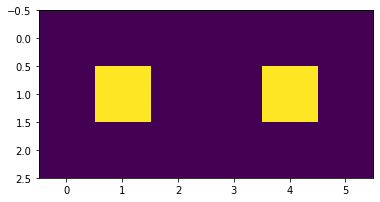

In [154]:
plt.imshow( fplus ); # Нашли два случая.

In [155]:
oplus = np.zeros_like( plusses )

In [156]:
apply_traff( plusses, oplus, [plus])

До этого введенный трафарет искал только полное совпадение. Тогда он убирал точку (а не ставил).

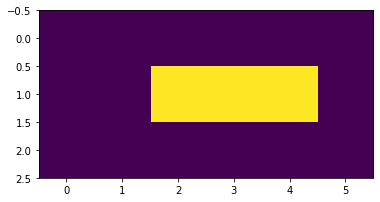

In [157]:
plt.imshow( oplus );

In [158]:
plusses[:,1:4] == plus 

array([[False, False,  True],
       [ True,  True,  True],
       [False, False,  True]])

In [159]:
(plusses[:,1:4]==plus).all()

False

<b>Разделение компонент</b>

В данном случае мы будем фактически отрезать тонкий слой от всех границ.

Исходные компоненты слиплись.
Их нужно отделить друг от друга.

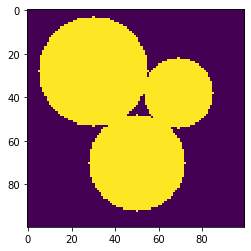

In [193]:
img_touch = np.zeros((100,100), 'uint8')
cv.circle( img_touch, (30, 28), 25, 1, -1);
cv.circle( img_touch, (50, 70), 22, 1, -1);
cv.circle( img_touch, (69, 38), 16, 1, -1);
plt.imshow( img_touch, interpolation = 'none' );

In [210]:
img_ntouch = np.zeros_like( img_touch )

In [211]:
for i in range( 1, img_touch.shape[0] - 1 ):
    for j in range( 1, img_touch.shape[1] - 1 ):
        v = img_touch[i,j]
        if v==0:
            continue
        m = img_touch[i-1:i+2,j-1:j+2]
        img_ntouch[i,j] = 9 == np.sum(m);

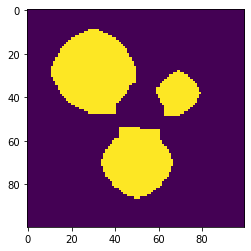

In [212]:
plt.imshow( img_ntouch, interpolation = 'none' );

In [213]:
img_touch = img_ntouch.copy() # Делаем копию изображения.
# Нужно выполнять предыдущие три блока пока не разделяться.

Сделаем то же самое только теперь с окном 9х9

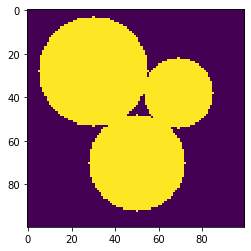

In [214]:
img_touch = np.zeros((100,100), 'uint8')
cv.circle( img_touch, (30, 28), 25, 1, -1);
cv.circle( img_touch, (50, 70), 22, 1, -1);
cv.circle( img_touch, (69, 38), 16, 1, -1);
plt.imshow( img_touch, interpolation = 'none' );

In [215]:
for i in range( 4, img_touch.shape[0] - 4 ):
    for j in range( 4, img_touch.shape[1] - 4 ):
        v = img_touch[i,j]
        if v==0:
            continue
        m = img_touch[i-4:i+5,j-4:j+5]
        img_ntouch[i,j] = 81 == np.sum(m);

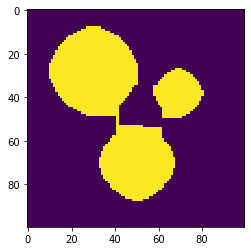

In [216]:
plt.imshow( img_ntouch, interpolation = 'none' );

In [ ]:
Упраж.
увеличтье размер трафарета дальше.

<b>Наращивание</b>

По аналогии.